In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as mdl
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os
print(os.listdir("E:/THESIS MALARIA/cell_images/"))

['Parasitized', 'Uninfected']


In [6]:
img_dir="E:/THESIS MALARIA/cell_images/"

In [7]:
path=Path(img_dir)
path

WindowsPath('E:/THESIS MALARIA/cell_images')

In [8]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [9]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Parasitized', 'Uninfected']


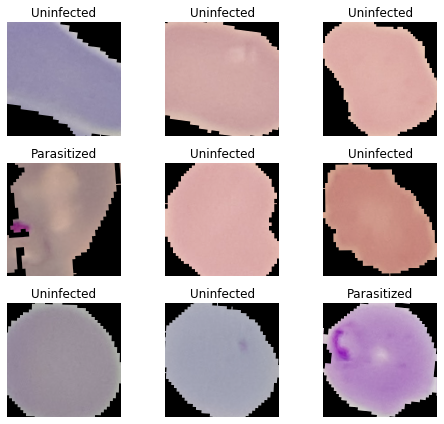

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
learn = create_cnn(data, mdl.vgg16, metrics=accuracy, model_dir="/tmp/model/")

C:\ProgramData\Anaconda3\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


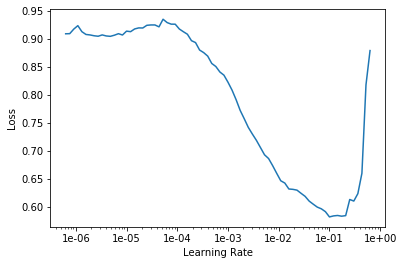

In [9]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(4,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.223854,4571.619629,0.943386,07:00
1,0.198524,0.185164,0.937398,06:58
2,0.182681,0.154601,0.951551,07:03
3,0.160143,6836.277832,0.955181,07:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


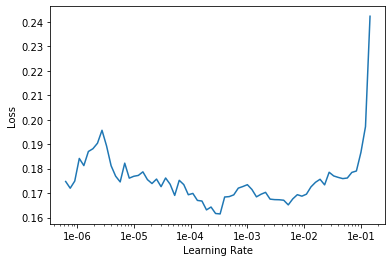

In [12]:
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,5e-5 ))

epoch,train_loss,valid_loss,accuracy,time
0,0.161538,1.279247,0.954999,06:54
1,0.167630,6903.384277,0.954818,06:32
2,0.169479,12.381449,0.955181,06:55
3,0.165479,2456819.000000,0.954636,06:55


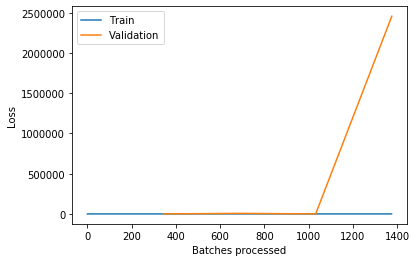

In [14]:
learn.save('stage-2')
learn.recorder.plot_losses()

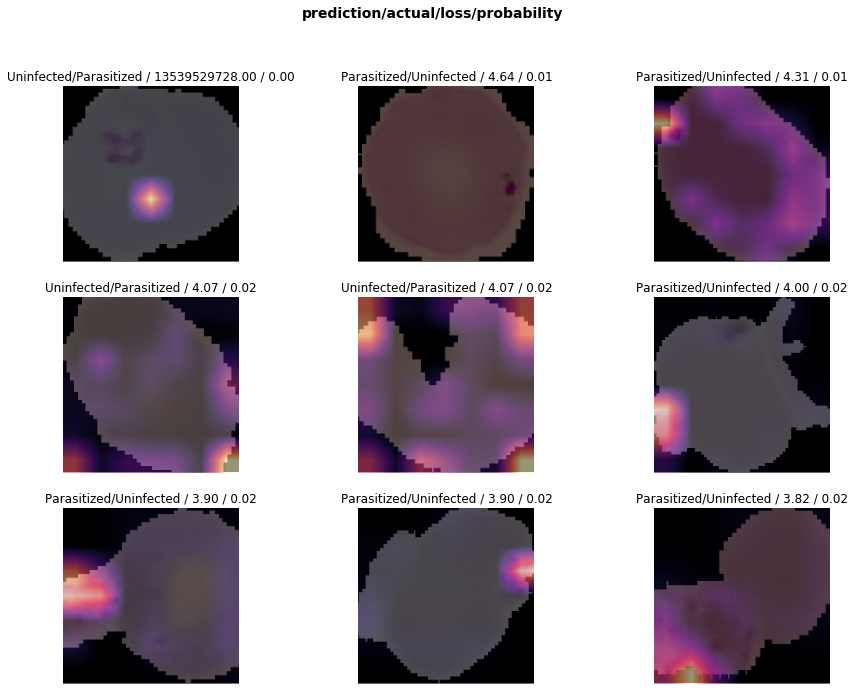

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

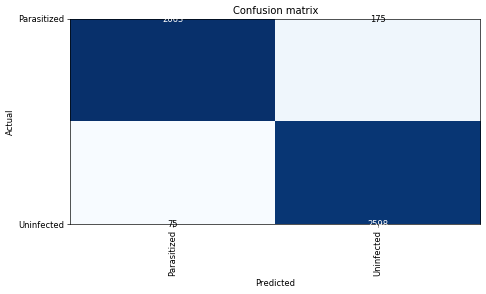

In [16]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [2]:
interp.most_confused(min_val=2)

NameError: name 'interp' is not defined

In [18]:
pred_data= ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [19]:
predictor=cnn_learner(data, mdl.vgg16, metrics=accuracy, model_dir="/tmp/model/").load('stage-2')
pred_data.single_from_classes(path, pred_data.classes)

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: E:\THESIS MALARIA\cell_images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: E:\THESIS MALARIA\cell_images;

Test: None

Category Uninfected

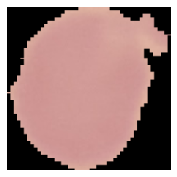

In [20]:
x,y = data.valid_ds[3]
x.show()
data.valid_ds.y[3]

In [21]:
pred_class,pred_idx,outputs = predictor.predict(x)
pred_class

Category Uninfected

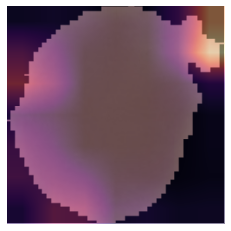

In [22]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.5, extent=size,
              interpolation='bilinear', cmap='magma')
    
heatMap(x,y,pred_data,learn)